In [1]:
energy = 0.9
pressure= .004
tempSpike = 0
radius = 0
lattice = "lattice.gsd"
random = "random.gsd"
logStableLiquid = "logStableLiquid"+"energy"+(str(energy).replace(".", ""))+".h5"
output = "random"+"energy"+(str(energy).replace(".", ""))+".gsd"


In [2]:
import itertools
import math
import gsd.hoomd
import hoomd
import numpy as np
import matplotlib.pyplot as plt
import fresnel
import scipy
import h5py
import time
import matplotlib
import importlib
import os
#sbctc = importlib.import_module('thermocalcs',package='/home/tiarice/MDsims/sbcmd')
os.chdir('/home/tiarice/MDsims')
import sbcmd.thermocalcs as sbctc
import sbcmd.visualization as vis
import sbcmd.updated_surfacetension as surftens
os.chdir('/home/tiarice/MDsims/Sandboxes/Tia/md_simulation/Energy_09_Cavetation')

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
import os

if os.path.exists(lattice):
    os.remove(lattice) # clear file if already created
if os.path.exists(random):
    os.remove(random) # clear file if already created

In [4]:
fn = os.path.join(os.getcwd(), lattice)
![ -e "$fn" ] && rm "$fn"
fn = os.path.join(os.getcwd(), random)
![ -e "$fn" ] && rm "$fn"

In [5]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [6]:
# m = 10
# N_particles = 2 * m**5 #number of particles (2e5)
Lx = np.float64(50.0)  
Ly = np.float64(50.0) 
Lz = np.float64(100.0)
# manually finding the vertices instead of itertools


In [7]:
# Manually finding the vertices instead of itertools
# start in more realistic configuration
position = sbctc.FillBoxFccLattice(Lx*np.float64([-.5,.5]),
                       Ly*np.float64([-.5,.5]),
                       Lz*np.float64([-.5,.5]),
                       np.float64(0.75)) #density
# can calculate density at end
N_particles = position.shape[0]

In [8]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position#[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [Lx, Ly, Lz, 0, 0, 0]
frame.particles.types = ['A']

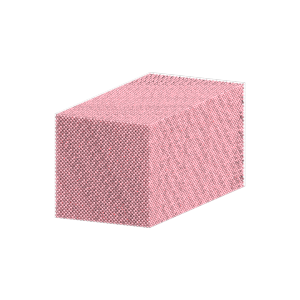

In [9]:
render(frame)

In [10]:
with gsd.hoomd.open(name=lattice, mode='x') as f:
    f.append(frame)

In [11]:
gpu = hoomd.device.GPU()
simulation = hoomd.Simulation(device=gpu, seed=1)
simulation.create_state_from_gsd(filename=lattice)

In [12]:
integrator = hoomd.md.Integrator(dt=1e-3) 
cell = hoomd.md.nlist.Cell(buffer=0.2) # 0.4 decrease buffer to reduce the number of neighbors
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 3.0 # usually 2.5 but we care about Surface Tension so 5 or larger
integrator.forces.append(lj)

In [13]:
simulation.operations.integrator = integrator

In [14]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(1)

In [15]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists(logStableLiquid):
    os.remove(logStableLiquid) # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(100), # change how often logger collects here; 
                                  filename=logStableLiquid,
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [16]:
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=energy))
integrator.methods.append(nvt)

In [17]:
snapshot = simulation.state.get_snapshot() #Setting random velocities
snapshot.particles.velocity[0:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [18]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=energy)

In [19]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

-5.188942509548555

In [20]:
thermodynamic_properties.volume

250000.0

In [21]:
thermodynamic_properties.degrees_of_freedom

555576.0

In [22]:
1 / 2 * 1.5 * thermodynamic_properties.degrees_of_freedom

416682.0

In [23]:
thermodynamic_properties.kinetic_energy

249284.00218542686

In [24]:
thermodynamic_properties.kinetic_temperature

0.8973893839382078

In [25]:
simulation.run(40000) # was 100000
#surftens.RunSurfaceTensionCalc()

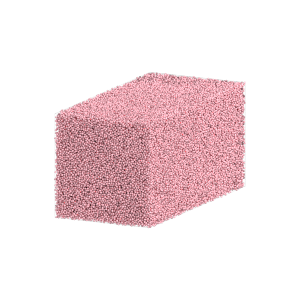

In [26]:
render(simulation.state.get_snapshot())

In [27]:
# simulation.always_compute_pressure = True
# simulation.run(1)
# simulation.always_compute_pressure = False
# thermodynamic_properties.pressure

In [28]:
simulation.run(10000)

In [29]:
simulation.operations.writers.remove(hdf5_writer)
hdf5_file = h5py.File(name=logStableLiquid, mode='r')

In [30]:
# import h5py

# def print_hdf5_structure(name, obj):
#     print(name)

# with h5py.File('logStableLiquid.h5', 'r') as hdf5_file:
#     hdf5_file.visititems(print_hdf5_structure)

In [31]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [32]:
# print("Pressure Data:", pressure_data)

In [33]:
print("Temp Data:", temperature_data)

Temp Data: [0.89602383 0.90147609 0.90254707 0.89998169 0.89877727 0.89909624
 0.9022126  0.90141713 0.90189414 0.89997171 0.90220782 0.89828439
 0.8998003  0.89941371 0.89987353 0.89913405 0.89994711 0.90023722
 0.89786715 0.90129535 0.89709897 0.89982879 0.89947677 0.9003571
 0.90359409 0.89838338 0.90107033 0.89999858 0.89995239 0.89657538
 0.90065158 0.89863028 0.90079174 0.89905718 0.89665491 0.89832651
 0.90133754 0.89923815 0.89883409 0.90122439 0.90406675 0.90126585
 0.90050686 0.89876912 0.89940851 0.89908761 0.89783533 0.90176624
 0.89913456 0.9022879  0.90041399 0.90330673 0.90046362 0.90013553
 0.90080698 0.90178544 0.90143666 0.89798932 0.89843232 0.90192037
 0.90072723 0.90357852 0.89920939 0.89958271 0.90024366 0.90196015
 0.90165003 0.90148295 0.90096054 0.89629724 0.89999529 0.89895083
 0.8989731  0.89863151 0.89932659 0.89838562 0.90166757 0.89896063
 0.90308455 0.90128374 0.90418869 0.90048124 0.90122953 0.90150312
 0.90132292 0.90165932 0.90011955 0.90092105 0.90133

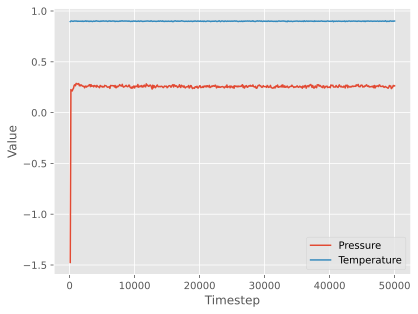

In [34]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, temperature_data, label='Temperature')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

In [35]:
thermodynamic_properties.kinetic_energy

249510.3131104597

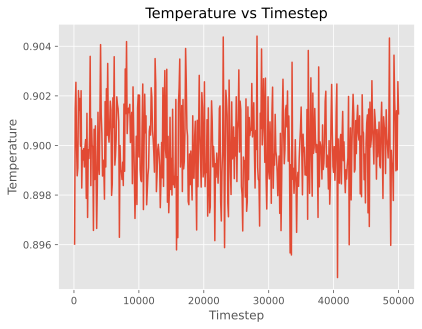

In [36]:
plt.plot(timesteps, temperature_data)
plt.title('Temperature vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.show()

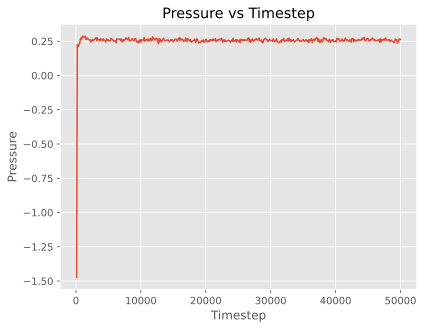

In [37]:
plt.plot(timesteps, pressure_data)
plt.title('Pressure vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Pressure')
plt.show()

In [38]:
if os.path.exists(output):
    os.remove(output) # clear file if already created
hoomd.write.GSD.write(state=simulation.state, filename=output, mode='xb')

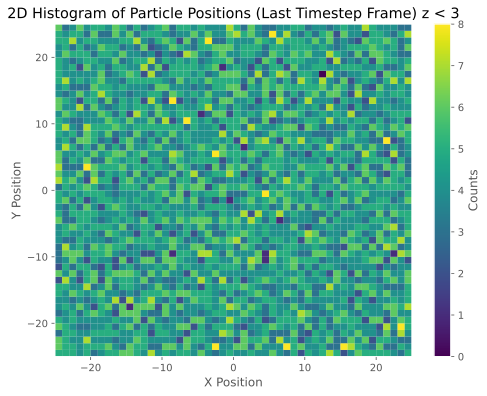

In [39]:
vis.colormap_histogram(output)